In [1]:
import os
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

import WindowDataset
import CustomModels
import CustomMetrics
import CustomWindowGenerator

from tensorflow.keras import backend as K

%load_ext autoreload
%autoreload 2

# DATASET

## Load Dataset

In [2]:
data_horaria_estandarizada_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Horaria_Estandarizada.xlsx')
data_horaria_estandarizada = pd.read_excel(data_horaria_estandarizada_path)
data_horaria_estandarizada = data_horaria_estandarizada.set_index('Fecha')

In [3]:
precio_bolsa_path = os.path.join('..','..','dataset','Series','Sabanas','Estandarizada','Sabana_Datos_Precio_Bolsa_Estandarizada.xlsx')
precio_bolsa = pd.read_excel(precio_bolsa_path)
precio_bolsa = precio_bolsa.set_index('Fecha')

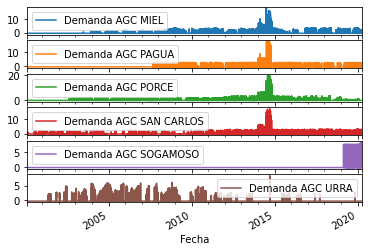

In [4]:
plot_cols = data_horaria_estandarizada.columns[-6:]
plot_features = data_horaria_estandarizada[plot_cols]
_ = plot_features.plot(subplots=True)

In [5]:
full_df = pd.concat([data_horaria_estandarizada,precio_bolsa],axis=1)
full_df.shape,data_horaria_estandarizada.shape,precio_bolsa.shape

((176760, 85), (176760, 84), (176760, 1))

In [6]:
train_df = full_df[(full_df.index >= '2000-01-01') & (full_df.index < '2019-01-01')]
val_df = full_df[(full_df.index >= '2019-01-01') & (full_df.index < '2020-01-01')]
test_df = full_df[full_df.index >= '2020-01-01']

train_df.shape,val_df.shape,test_df.shape

((165816, 85), (8760, 85), (2184, 85))

## Build Window

In [7]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA', 'Generacion CHIVOR',
          'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
          'Generacion GUAVIO', 'Generacion LA TASAJERA', 'Generacion MIEL',
          'Generacion PAGUA', 'Generacion PLAYAS', 'Generacion PORCE',
          'Generacion SAN CARLOS', 'Generacion SOGAMOSO', 'Generacion URRA','$kWh']
#output_columns = inputs_columns

#inputs_columns = ['$kWh']
output_columns = ['$kWh']



window_dataset = WindowDataset.WindowGenerator(input_width=24, label_width=1, shift=1,
                              train_df=train_df, val_df=val_df, test_df=test_df,
                              inputs_columns=inputs_columns,label_columns=output_columns,batch=8)

# MODELS

## Instantiate Models

In [8]:
custom_rnn  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Instantiate metrics dicts

In [9]:
val_performance = dict()
performance = dict()

## Compile & Fit Method

In [10]:
def compile_and_fit(model, window_train, window_val, epochs, steps_per_epoch, val_steps,patience):
    
    log_dir = os.path.join('logs',model.name)
    if not os.path.exists(log_dir):
        os.makedirs(log_dir)
    callback_tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                          histogram_freq=2,
                                                          write_graph=False,
                                                          update_freq='epoch')
    
    callback_reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                              factor=0.1,
                                                              min_lr=1e-4,
                                                              patience=0,
                                                              verbose=1)

    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=patience,
                                                      mode='min')
    
    callbacks = [callback_tensorboard,callback_reduce_lr,early_stopping]
    
    model.compile(loss=tf.losses.MeanSquaredError(),
                  optimizer=tf.optimizers.Adam(),
                  metrics=[tf.metrics.MeanAbsoluteError(),tf.keras.metrics.MeanAbsolutePercentageError(),
                           CustomMetrics.symmetric_mean_absolute_percentage_error])
    
    history = model.fit(x=window_train,epochs=epochs,steps_per_epoch=steps_per_epoch,
              validation_data=window_val,validation_steps=val_steps,callbacks=callbacks)
    
    return history

## Predictions & Plot

In [11]:
def generate_predictions_style_1(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las siguientes 24 horas tomadas del conjunto de Test y le agrega  la
    predicción realizada para predecir la siguiente hora (hora 26) y continua  así
    hasta realizar la predicción de todas las horas del subconjunto tomado de test.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)
    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model.predict(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

        first_signals = flat_inputs[0+i:24+i,:-1]
        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [12]:
def generate_predictions_style_2(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las siguientes 23 horas tomadas del conjunto de Test y repite el úl-
    timo valor conocido (osea el valor flat_input[23,:]) para poder completar  las
    24 horas, pero esto lo hace unicamente con las series que no estan   incluidas
    en output_columns, para las series que si estan incluidas en   output_columns,
    toma el valor predicho y lo agrega como último a la serie.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)

    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

            first_signals = flat_inputs[i:24,:-1]
            repeated_signals = tf.repeat(flat_inputs[23:24,:-1], i, axis=0)
            first_signals = tf.concat([first_signals,repeated_signals],axis=0)

        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [13]:
def generate_predictions_style_3(flat_inputs,model):
    """
    Esta función toma una sección del conjunto de Test y entrega predicciones para
    todas las horas posteriores a la 24. Para realizar esto, inicialmente se toman
    las primeras 24 horas de cada una de las series y predice la siguiente   hora,
    luego usa las mismas 24 de las series que no estan incluidas en output_columns 
    y para las series que si estan incluidas allí toma los 23 valores siguiente  y
    agrega la predicción realizada, así suscesivamente hasta acabar las    predic-
    ciones.
    Input:
        - flat_inputs: Tensor de dimensiones (n_batch*times,n_signals) que contiene
        los valores de las series para un subconjunto de test.
        - model: Modelo entrenado con el cual se realizaran las predicciones.
    Output:
        - predicted_signal: Tensor con dimensiones ((n_batch*times)-23,1) que  con-
        tiene todas las predicciones realizadas sobre el subconjunto de Test.
    """
    flat_inputs_size = flat_inputs.shape[0]

    signals_to_predict = tf.expand_dims(flat_inputs[0:24,:], axis=0)

    predicted_signal = list()
    predicted_signal_idx = 0

    for i in range(1,flat_inputs_size-23):

        predictions = model(signals_to_predict)
        predicted_signal.append(predictions)

        if i >= 24:
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.reshape(flat_predicted_signal[predicted_signal_idx:,-1], [-1,1])
            predicted_signal_idx += 1
        else:
            last_signal = tf.reshape(flat_inputs[i:24,-1], [-1,1])
            flat_predicted_signal = tf.reshape(tf.convert_to_tensor(predicted_signal),[-1,1])
            last_signal = tf.concat([last_signal,flat_predicted_signal],axis=0)

        first_signals = flat_inputs[:24,:-1]
        signals_to_predict = tf.concat([first_signals,last_signal],axis=1)
        signals_to_predict = tf.expand_dims(signals_to_predict, axis=0)
    
    return predicted_signal

In [14]:
def plot_comparison(signal_true,signal_pred):
    y_true = signal_true[24:,-1]
    y_pred = tf.reshape(tf.convert_to_tensor(signal_pred),[-1,1])
    
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(y_true, label='true')
    plt.plot(y_pred, label='pred')

    plt.ylabel('Precio en Bolsa Nacional')
    plt.legend()
    plt.show()

## Execute experiments

### Recurrent Neuronal Network

In [15]:
inputs = tf.keras.layers.Input(shape=(24,len(inputs_columns)))
custom_model = CustomModels.CustomRNN(rnn_units=83,output_units=len(output_columns))
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_rnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 83)                8300      
_________________________________________________________________
dense (Dense)                (None, 1)                 84        
Total params: 8,384
Trainable params: 8,384
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = compile_and_fit(model=custom_rnn, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
  1/150 [..............................] - ETA: 0s - loss: 1.1528 - mean_absolute_error: 0.8992 - mean_absolute_percentage_error: 437.2148 - symmetric_mean_absolute_percentage_error: 149.2221WARNING:tensorflow:From C:\Users\SEBASTIAN\anaconda3\envs\proyecto-grados\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
150/150 [==============================] - 4s 29ms/step - loss: 0.2708 - mean_absolute_error: 0.3049 - mean_absolute_percentage_error: 190.5527 - symmetric_mean_absolute_percentage_error: 76.3840 - val_loss: 0.1019 - val_mean_absolute_error: 0.2414 - val_mean_absolute_percentage_error: 1037.2660 - val_symmetric_mean_absolute_percentage_error: 60.3079
Epoch 2/100
150/150 [==============================] - 3s 23ms/step - loss: 0.1327 - mean_absolute_error: 0.1986 - mean_absolute_percenta

150/150 [==============================] - 3s 23ms/step - loss: 0.0387 - mean_absolute_error: 0.1061 - mean_absolute_percentage_error: 193.8768 - symmetric_mean_absolute_percentage_error: 39.0204 - val_loss: 0.0526 - val_mean_absolute_error: 0.1643 - val_mean_absolute_percentage_error: 462.1774 - val_symmetric_mean_absolute_percentage_error: 44.9638
Epoch 20/100
150/150 [==============================] - 3s 23ms/step - loss: 0.0317 - mean_absolute_error: 0.1010 - mean_absolute_percentage_error: 115.2194 - symmetric_mean_absolute_percentage_error: 37.4956 - val_loss: 0.0475 - val_mean_absolute_error: 0.1501 - val_mean_absolute_percentage_error: 422.6909 - val_symmetric_mean_absolute_percentage_error: 42.6332
Epoch 21/100
150/150 [==============================] - 4s 24ms/step - loss: 0.0375 - mean_absolute_error: 0.1107 - mean_absolute_percentage_error: 80.1341 - symmetric_mean_absolute_percentage_error: 38.5733 - val_loss: 0.0494 - val_mean_absolute_error: 0.1572 - val_mean_absolute_pe

In [17]:
val_performance['DNN'] = custom_rnn.evaluate(window_dataset.val)
performance['DNN'] = custom_rnn.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 4s 4ms/step - loss: 0.0628 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 211.1948 - symmetric_mean_absolute_percentage_error: 43.4506


In [18]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

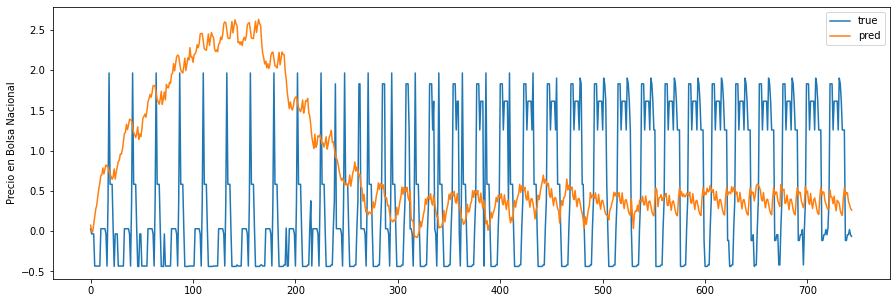

In [19]:
predictions = generate_predictions_style_1(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

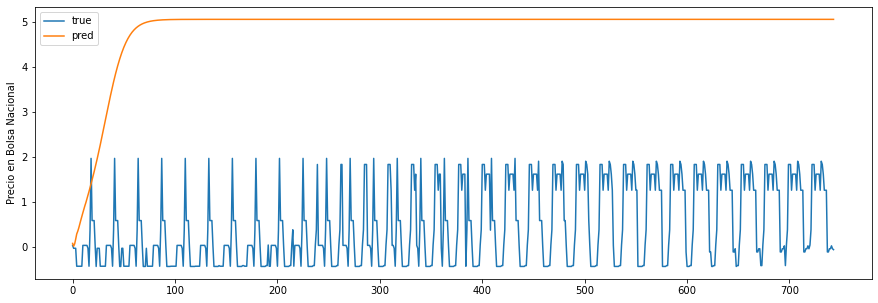

In [20]:
predicted_signal = generate_predictions_style_2(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predicted_signal)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

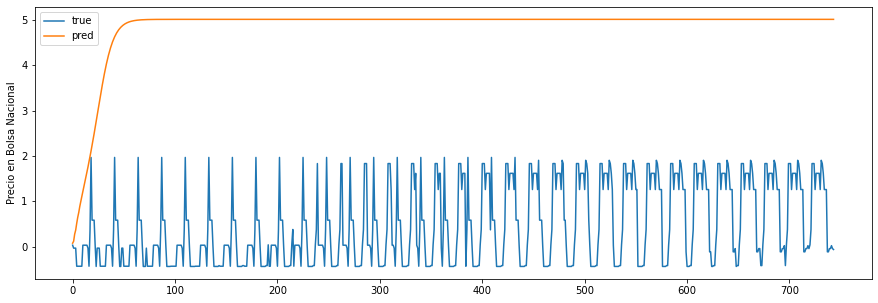

In [21]:
predicted_signal = generate_predictions_style_3(flat_inputs,custom_rnn)
plot_comparison(flat_inputs,predicted_signal)

### Long Short Term Memory

In [22]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomLSTM(lstm_units=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_lstm_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 83)                56108     
_________________________________________________________________
dense_1 (Dense)              (None, 85)                7140      
Total params: 63,248
Trainable params: 63,248
Non-trainable params: 0
_________________________________________________________________


In [23]:
history = compile_and_fit(model=custom_lstm, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 3s 22ms/step - loss: 0.1621 - mean_absolute_error: 0.2156 - mean_absolute_percentage_error: 212.2235 - symmetric_mean_absolute_percentage_error: 63.3582 - val_loss: 0.1202 - val_mean_absolute_error: 0.2662 - val_mean_absolute_percentage_error: 449.4145 - val_symmetric_mean_absolute_percentage_error: 63.4927
Epoch 2/100
142/150 [===========================>..] - ETA: 0s - loss: 0.0584 - mean_absolute_error: 0.1476 - mean_absolute_percentage_error: 155.1456 - symmetric_mean_absolute_percentage_error: 47.3601
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 [==============================] - 1s 9ms/step - loss: 0.0610 - mean_absolute_error: 0.1491 - mean_absolute_percentage_error: 150.2633 - symmetric_mean_absolute_percentage_error: 47.3540 - val_loss: 0.1770 - val_mean_absolute_error: 0.3448 - val_mean_absolute_percentage_error: 535.0899 - val_symmetric_mean_absolute_percentage_error: 83.6538
E

150/150 [==============================] - 1s 8ms/step - loss: 0.0352 - mean_absolute_error: 0.0943 - mean_absolute_percentage_error: 87.1239 - symmetric_mean_absolute_percentage_error: 35.3697 - val_loss: 0.0646 - val_mean_absolute_error: 0.1805 - val_mean_absolute_percentage_error: 329.4402 - val_symmetric_mean_absolute_percentage_error: 50.3570
Epoch 22/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0262 - mean_absolute_error: 0.0899 - mean_absolute_percentage_error: 61.8417 - symmetric_mean_absolute_percentage_error: 34.2591 - val_loss: 0.0677 - val_mean_absolute_error: 0.1874 - val_mean_absolute_percentage_error: 326.8616 - val_symmetric_mean_absolute_percentage_error: 50.9801
Epoch 23/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0275 - mean_absolute_error: 0.0951 - mean_absolute_percentage_error: 57.3234 - symmetric_mean_absolute_percentage_error: 34.7449 - val_loss: 0.0639 - val_mean_absolute_error: 0.1807 - val_mean_absolute_percent

Epoch 44/100
150/150 [==============================] - 1s 8ms/step - loss: 0.0471 - mean_absolute_error: 0.0963 - mean_absolute_percentage_error: 54.3469 - symmetric_mean_absolute_percentage_error: 31.1342 - val_loss: 0.0543 - val_mean_absolute_error: 0.1612 - val_mean_absolute_percentage_error: 242.0396 - val_symmetric_mean_absolute_percentage_error: 44.9115


In [24]:
val_performance['LSTM'] = custom_lstm.evaluate(window_dataset.val)
performance['LSTM'] = custom_lstm.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 3s 3ms/step - loss: 0.0617 - mean_absolute_error: 0.1675 - mean_absolute_percentage_error: 211.5991 - symmetric_mean_absolute_percentage_error: 44.7028


In [25]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

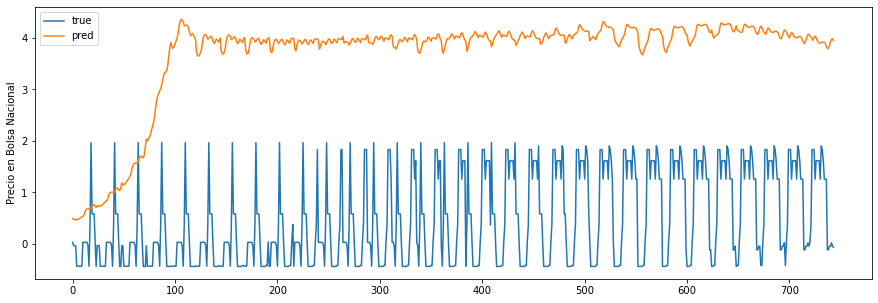

In [26]:
predictions = generate_predictions_style_1(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

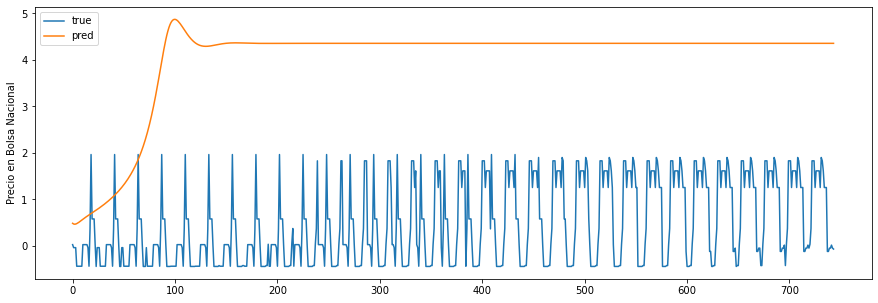

In [27]:
predictions = generate_predictions_style_2(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

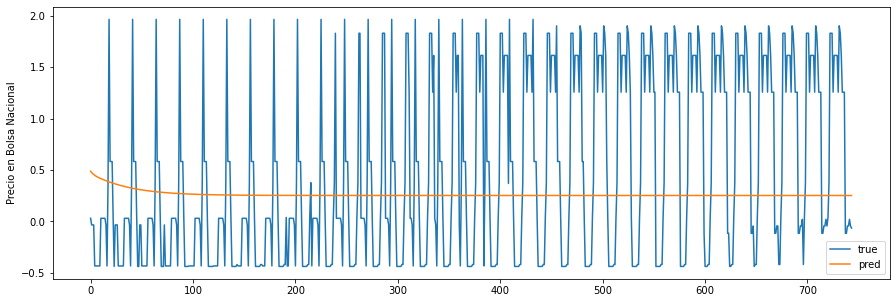

In [28]:
predictions = generate_predictions_style_3(flat_inputs,custom_lstm)
plot_comparison(flat_inputs,predictions)

### Gated Recurrent Unit

In [29]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomGRU(gru_units=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_gru_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 83)                42330     
_________________________________________________________________
dense_2 (Dense)              (None, 85)                7140      
Total params: 49,470
Trainable params: 49,470
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = compile_and_fit(model=custom_gru, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 12s 82ms/step - loss: 0.1677 - mean_absolute_error: 0.1988 - mean_absolute_percentage_error: 163.9553 - symmetric_mean_absolute_percentage_error: 55.8548 - val_loss: 0.1015 - val_mean_absolute_error: 0.2359 - val_mean_absolute_percentage_error: 123.0781 - val_symmetric_mean_absolute_percentage_error: 60.0625
Epoch 2/100
150/150 [==============================] - ETA: 0s - loss: 0.0380 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 97.7773 - symmetric_mean_absolute_percentage_error: 41.4161
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 [==============================] - 10s 64ms/step - loss: 0.0380 - mean_absolute_error: 0.1193 - mean_absolute_percentage_error: 97.7773 - symmetric_mean_absolute_percentage_error: 41.4161 - val_loss: 0.1026 - val_mean_absolute_error: 0.2399 - val_mean_absolute_percentage_error: 83.8303 - val_symmetric_mean_absolute_percentage_error: 55.5556
E

In [31]:
val_performance['GRU'] = custom_gru.evaluate(window_dataset.val)
performance['GRU'] = custom_gru.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 7s 6ms/step - loss: 0.0606 - mean_absolute_error: 0.1560 - mean_absolute_percentage_error: 143.8985 - symmetric_mean_absolute_percentage_error: 41.3086


In [32]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

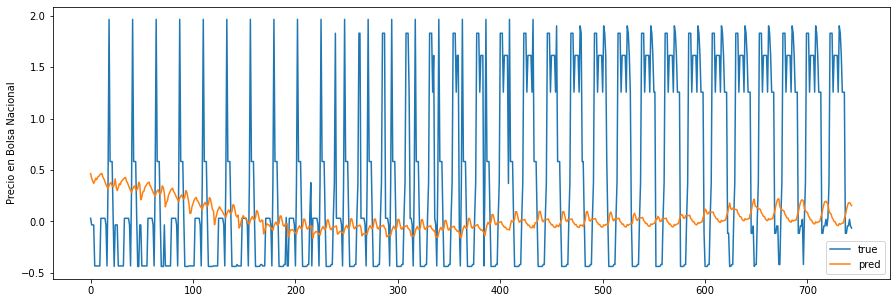

In [33]:
predictions = generate_predictions_style_1(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

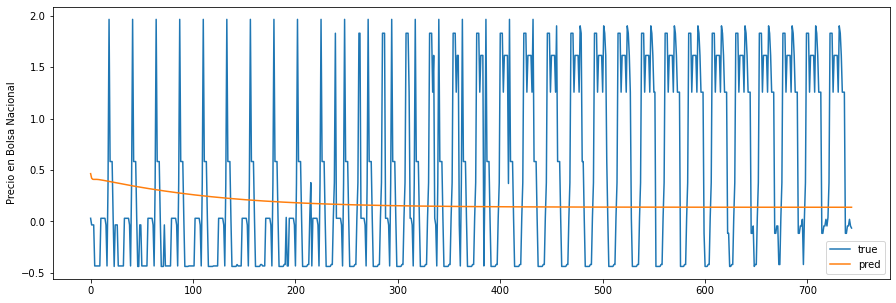

In [34]:
predictions = generate_predictions_style_2(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

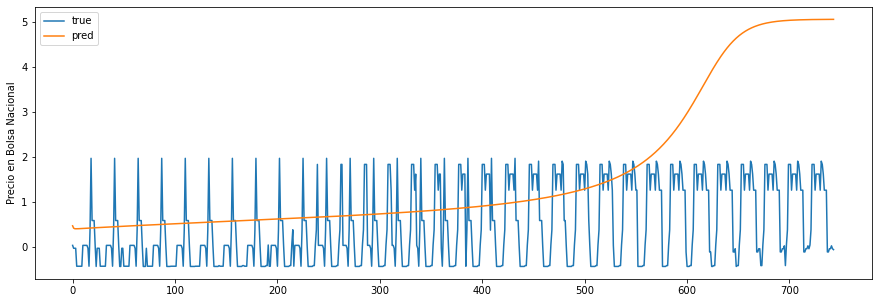

In [35]:
predictions = generate_predictions_style_3(flat_inputs,custom_gru)
plot_comparison(flat_inputs,predictions)

### Convolutional Neuronal Network

In [36]:
inputs = tf.keras.layers.Input(shape=(24,85))
custom_model = CustomModels.CustomCNN(dropout_rate=83,output_units=85)
x = custom_model(inputs, training=False)
custom_model.summary()

Model: "custom_cnn_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 23, 64)            10944     
_________________________________________________________________
batch_normalization (BatchNo (None, 23, 64)            256       
_________________________________________________________________
activation (Activation)      (None, 23, 64)            0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 64)            0         
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 85)               

In [37]:
history = compile_and_fit(model=custom_cnn, window_train=window_dataset.train,
                          window_val=window_dataset.val,epochs=100,
                          steps_per_epoch=150,val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 3s 23ms/step - loss: 1.0651 - mean_absolute_error: 0.7153 - mean_absolute_percentage_error: 879.5944 - symmetric_mean_absolute_percentage_error: 123.8542 - val_loss: 0.5251 - val_mean_absolute_error: 0.5796 - val_mean_absolute_percentage_error: 1625.8466 - val_symmetric_mean_absolute_percentage_error: 88.2550
Epoch 2/100
150/150 [==============================] - 1s 7ms/step - loss: 0.5259 - mean_absolute_error: 0.5686 - mean_absolute_percentage_error: 521.0762 - symmetric_mean_absolute_percentage_error: 114.9688 - val_loss: 0.2451 - val_mean_absolute_error: 0.3728 - val_mean_absolute_percentage_error: 590.1899 - val_symmetric_mean_absolute_percentage_error: 77.7121
Epoch 3/100
140/150 [===========================>..] - ETA: 0s - loss: 0.5927 - mean_absolute_error: 0.5323 - mean_absolute_percentage_error: 389.0112 - symmetric_mean_absolute_percentage_error: 110.2261
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001000

Epoch 21/100
150/150 [==============================] - 1s 9ms/step - loss: 0.3180 - mean_absolute_error: 0.4369 - mean_absolute_percentage_error: 499.7061 - symmetric_mean_absolute_percentage_error: 100.3314 - val_loss: 0.1793 - val_mean_absolute_error: 0.3063 - val_mean_absolute_percentage_error: 747.7810 - val_symmetric_mean_absolute_percentage_error: 67.4300
Epoch 22/100
150/150 [==============================] - 1s 9ms/step - loss: 0.3842 - mean_absolute_error: 0.4488 - mean_absolute_percentage_error: 317.3881 - symmetric_mean_absolute_percentage_error: 102.8321 - val_loss: 0.1730 - val_mean_absolute_error: 0.2999 - val_mean_absolute_percentage_error: 1020.7550 - val_symmetric_mean_absolute_percentage_error: 67.8736
Epoch 23/100
150/150 [==============================] - 1s 10ms/step - loss: 0.3287 - mean_absolute_error: 0.4330 - mean_absolute_percentage_error: 291.3705 - symmetric_mean_absolute_percentage_error: 100.1572 - val_loss: 0.1640 - val_mean_absolute_error: 0.2920 - val_

In [38]:
val_performance['CNN'] = custom_cnn.evaluate(window_dataset.val)
performance['CNN'] = custom_cnn.evaluate(window_dataset.test, verbose=0)

1092/1092 [==============================] - 4s 4ms/step - loss: 0.1741 - mean_absolute_error: 0.3161 - mean_absolute_percentage_error: 478.3068 - symmetric_mean_absolute_percentage_error: 68.9816


In [39]:
example = window_dataset.test.take(1)
inputs, labels = next(iter(example))

flat_inputs = tf.reshape(inputs, [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

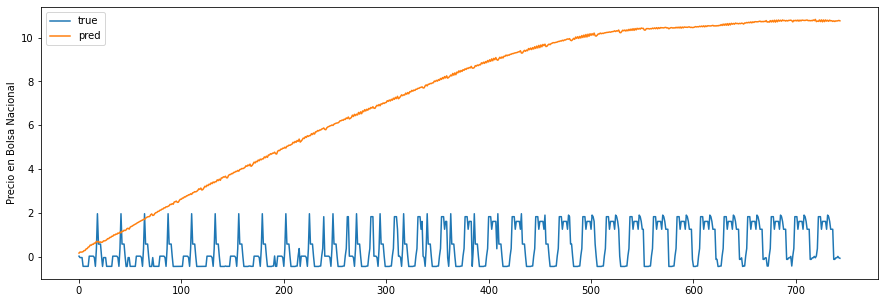

In [40]:
predictions = generate_predictions_style_1(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

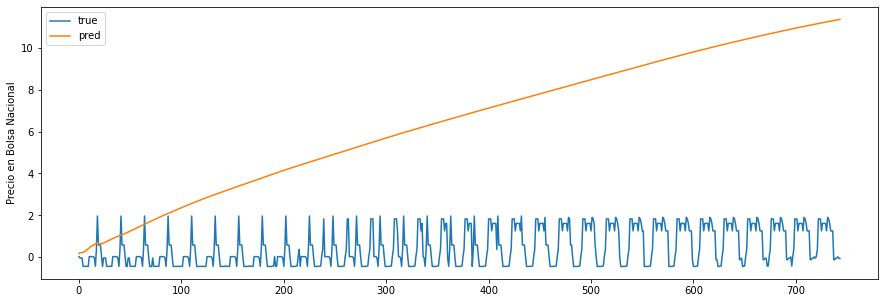

In [41]:
predictions = generate_predictions_style_2(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

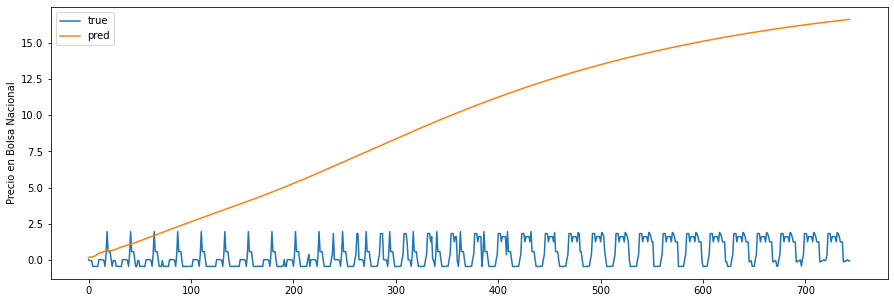

In [42]:
predictions = generate_predictions_style_3(flat_inputs,custom_cnn)
plot_comparison(flat_inputs,predictions)

## Metrics Summary

In [43]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.062829,0.164816,211.194794,43.450615
LSTM,0.061678,0.167471,211.599091,44.702759
GRU,0.060610,0.156033,143.898468,41.308571
CNN,0.174074,0.316144,478.306793,68.981598


In [44]:
pd.DataFrame(performance,index=['Loss','Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.067221,0.183556,17.724922,15.175248
LSTM,0.067879,0.176284,21.216074,15.013794
GRU,0.068111,0.167208,19.837584,13.839369
CNN,0.187879,0.328300,53.197319,23.715986


# MODELO DE DATOS PROPIO

In [45]:
inputs_columns = ['Generacion ALBAN', 'Generacion BETANIA',      'Generacion CHIVOR',
                  'Generacion EL QUIMBO', 'Generacion GUATAPE', 'Generacion GUATRON',
                  'Generacion GUAVIO', 'Generacion LA TASAJERA',   'Generacion MIEL',
                  'Generacion PAGUA', 'Generacion PLAYAS',        'Generacion PORCE',
                  'Generacion SAN CARLOS', 'Generacion SOGAMOSO',  'Generacion URRA',
                  '$kWh']

output_columns = ['$kWh']

column_indices = {name: i for i, name in enumerate(full_df)}
times = 24
shift = 1

In [46]:
samples = train_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_train, y_train = custom_window_generator.data_build(train_df)
train_generator = custom_window_generator.batch_generator(x=x_train,y=y_train,batches=8)

x_batch, y_batch = next(train_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

In [47]:
samples = val_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_val, y_val = custom_window_generator.data_build(val_df)
val_generator = custom_window_generator.batch_generator(x_val, y_val,batches=8)

x_batch, y_batch = next(val_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

In [48]:
samples = test_df.shape[0] - (times+shift)
custom_window_generator = CustomWindowGenerator.WindowGenerator(samples=samples,
                                                                times=times,
                                                                shift=shift,
                                                                inputs_columns=inputs_columns,
                                                                output_columns=output_columns,
                                                                column_indices=column_indices)

x_test, y_test = custom_window_generator.data_build(test_df)
test_generator = custom_window_generator.batch_generator(x_test, y_test,batches=8,shuffle=False)

x_batch, y_batch = next(test_generator)
x_batch.shape,y_batch.shape

((8, 24, 16), (8, 24, 1))

## Instantiate Models

In [49]:
custom_rnn_2  = CustomModels.CustomRNN(rnn_units=90,output_units=len(output_columns))
custom_lstm_2 = CustomModels.CustomLSTM(lstm_units=83,output_units=len(output_columns))
custom_gru_2  = CustomModels.CustomGRU(gru_units=90,output_units=len(output_columns))
custom_cnn_2  = CustomModels.CustomCNN(dropout_rate=0.31,output_units=len(output_columns))

## Execute Experiments

### Recurrent Neuronal Network

In [50]:
history = compile_and_fit(model=custom_rnn_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 6s 40ms/step - loss: 0.4188 - mean_absolute_error: 0.3594 - mean_absolute_percentage_error: 247.6635 - symmetric_mean_absolute_percentage_error: 2078.1204 - val_loss: 0.1248 - val_mean_absolute_error: 0.2634 - val_mean_absolute_percentage_error: 1125.4874 - val_symmetric_mean_absolute_percentage_error: 1518.2261
Epoch 2/100
148/150 [============================>.] - ETA: 0s - loss: 0.1470 - mean_absolute_error: 0.2132 - mean_absolute_percentage_error: 191.1844 - symmetric_mean_absolute_percentage_error: 1463.1472 ETA: 1s - loss: 0.1139 - mean_absolute_error: 0.1947 - mean_absolute_percentage_error: 19
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
150/150 [==============================] - 4s 24ms/step - loss: 0.1456 - mean_absolute_error: 0.2126 - mean_absolute_percentage_error: 189.5772 - symmetric_mean_absolute_percentage_error: 1457.0107 - val_loss: 0.1261 - val_mean_absolute_error: 0.2614 - va

In [51]:
val_performance['RNN-CustomDataset'] = custom_rnn_2.evaluate(val_generator,steps=100)
performance['RNN-CustomDataset'] = custom_rnn_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 1s 7ms/step - loss: 0.0844 - mean_absolute_error: 0.1971 - mean_absolute_percentage_error: 199.5395 - symmetric_mean_absolute_percentage_error: 1194.3962


In [52]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

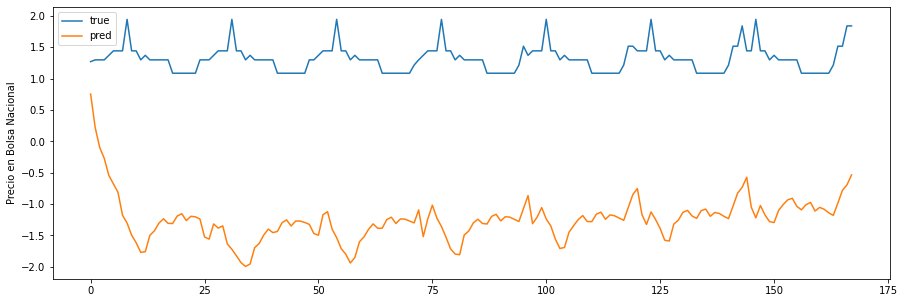

In [53]:
predictions = generate_predictions_style_1(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

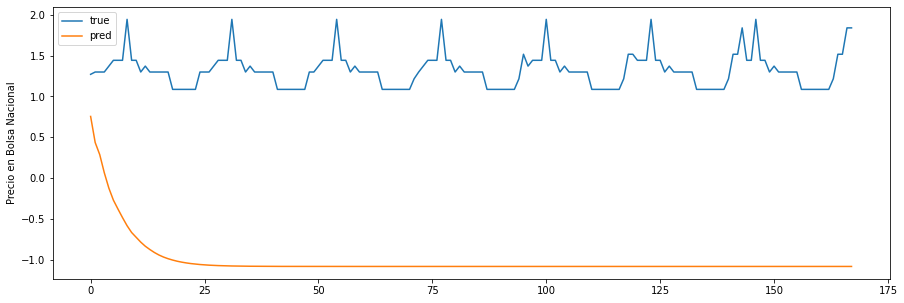

In [54]:
predictions = generate_predictions_style_2(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

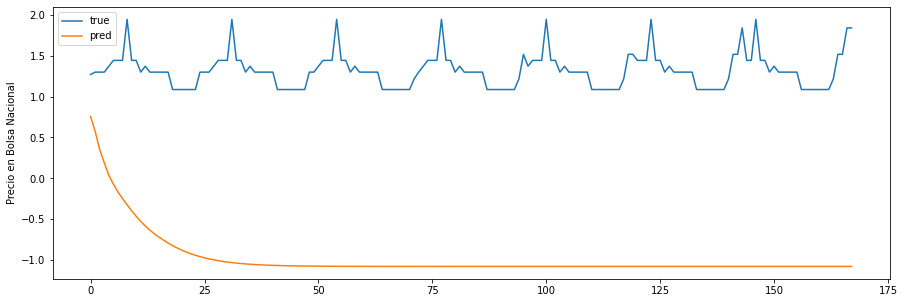

In [55]:
predictions = generate_predictions_style_3(flat_inputs,custom_rnn_2)
plot_comparison(flat_inputs,predictions)

### Long Short Term Memory

In [56]:
history = compile_and_fit(model=custom_lstm_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 5s 30ms/step - loss: 0.2859 - mean_absolute_error: 0.2367 - mean_absolute_percentage_error: 126.9038 - symmetric_mean_absolute_percentage_error: 1530.0045 - val_loss: 0.2089 - val_mean_absolute_error: 0.3566 - val_mean_absolute_percentage_error: 200.2403 - val_symmetric_mean_absolute_percentage_error: 1934.1162
Epoch 2/100
150/150 [==============================] - 2s 14ms/step - loss: 0.1257 - mean_absolute_error: 0.1648 - mean_absolute_percentage_error: 194.4840 - symmetric_mean_absolute_percentage_error: 1206.0330 - val_loss: 0.1575 - val_mean_absolute_error: 0.2686 - val_mean_absolute_percentage_error: 114.5051 - val_symmetric_mean_absolute_percentage_error: 1365.8607
Epoch 3/100
150/150 [==============================] - 2s 14ms/step - loss: 0.0519 - mean_absolute_error: 0.1334 - mean_absolute_percentage_error: 83.8225 - symmetric_mean_absolute_percentage_error: 1048.9449 - val_loss: 0.1344 - val_mean_absolute_error: 0.2956 - 

150/150 [==============================] - 2s 13ms/step - loss: 0.0277 - mean_absolute_error: 0.0874 - mean_absolute_percentage_error: 98.2623 - symmetric_mean_absolute_percentage_error: 758.0175 - val_loss: 0.0580 - val_mean_absolute_error: 0.1723 - val_mean_absolute_percentage_error: 626.6138 - val_symmetric_mean_absolute_percentage_error: 1107.9659
Epoch 21/100
150/150 [==============================] - 2s 14ms/step - loss: 0.0275 - mean_absolute_error: 0.0865 - mean_absolute_percentage_error: 112.0740 - symmetric_mean_absolute_percentage_error: 818.6808 - val_loss: 0.0639 - val_mean_absolute_error: 0.1742 - val_mean_absolute_percentage_error: 835.3575 - val_symmetric_mean_absolute_percentage_error: 1136.2603
Epoch 22/100
150/150 [==============================] - 2s 13ms/step - loss: 0.0342 - mean_absolute_error: 0.0929 - mean_absolute_percentage_error: 57.3664 - symmetric_mean_absolute_percentage_error: 765.3546 - val_loss: 0.0632 - val_mean_absolute_error: 0.1733 - val_mean_absol

In [57]:
val_performance['LSTM-CustomDataset'] = custom_cnn.evaluate(val_generator,steps=100)
performance['LSTM-CustomDataset'] = custom_cnn.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 0s 4ms/step - loss: 0.1573 - mean_absolute_error: 0.3054 - mean_absolute_percentage_error: 444.3010 - symmetric_mean_absolute_percentage_error: 1676.2024


In [58]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

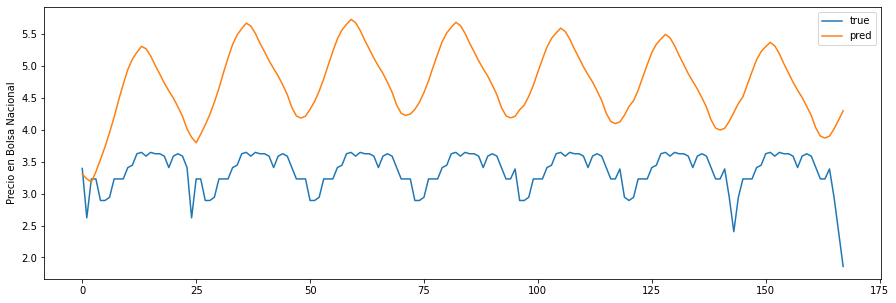

In [59]:
predictions = generate_predictions_style_1(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

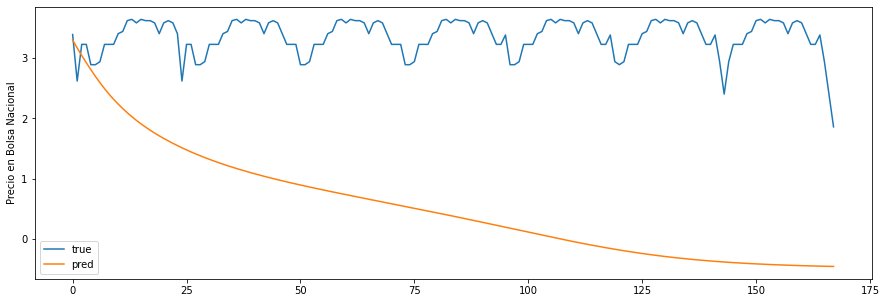

In [60]:
predictions = generate_predictions_style_2(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

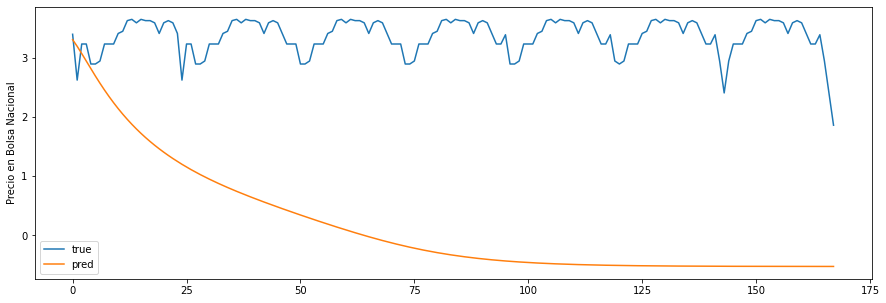

In [61]:
predictions = generate_predictions_style_3(flat_inputs,custom_lstm_2)
plot_comparison(flat_inputs,predictions)

### Gated Recurrent Unit

In [62]:
history = compile_and_fit(model=custom_gru_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 6s 37ms/step - loss: 0.2967 - mean_absolute_error: 0.2269 - mean_absolute_percentage_error: 97.7206 - symmetric_mean_absolute_percentage_error: 1485.0349 - val_loss: 0.1130 - val_mean_absolute_error: 0.2395 - val_mean_absolute_percentage_error: 136.2064 - val_symmetric_mean_absolute_percentage_error: 1323.4890
Epoch 2/100
150/150 [==============================] - 2s 12ms/step - loss: 0.1409 - mean_absolute_error: 0.1666 - mean_absolute_percentage_error: 361.3358 - symmetric_mean_absolute_percentage_error: 1144.1708 - val_loss: 0.0904 - val_mean_absolute_error: 0.2091 - val_mean_absolute_percentage_error: 310.8382 - val_symmetric_mean_absolute_percentage_error: 1197.4528
Epoch 3/100
147/150 [============================>.] - ETA: 0s - loss: 0.0546 - mean_absolute_error: 0.1221 - mean_absolute_percentage_error: 95.5257 - symmetric_mean_absolute_percentage_error: 943.9852
Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.000

In [63]:
val_performance['GRU-CustomDataset'] = custom_gru_2.evaluate(val_generator,steps=100)
performance['GRU-CustomDataset'] = custom_gru_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 1s 5ms/step - loss: 0.0700 - mean_absolute_error: 0.1572 - mean_absolute_percentage_error: 256.6704 - symmetric_mean_absolute_percentage_error: 988.9914


In [64]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

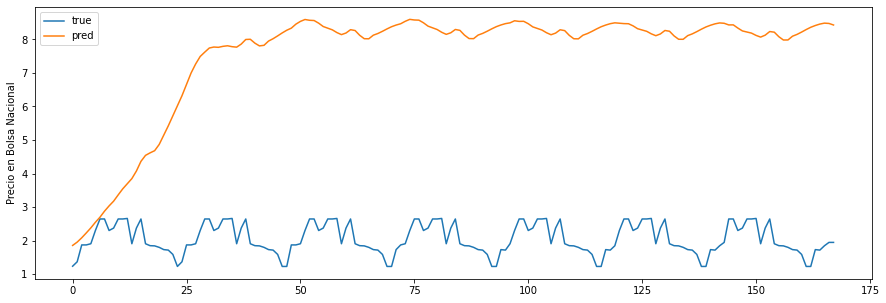

In [65]:
predictions = generate_predictions_style_1(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

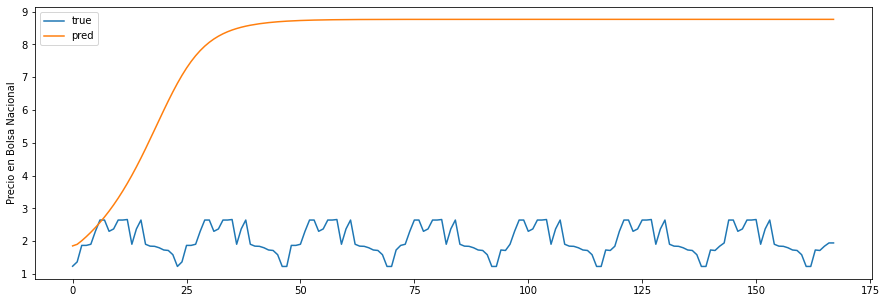

In [66]:
predictions = generate_predictions_style_2(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

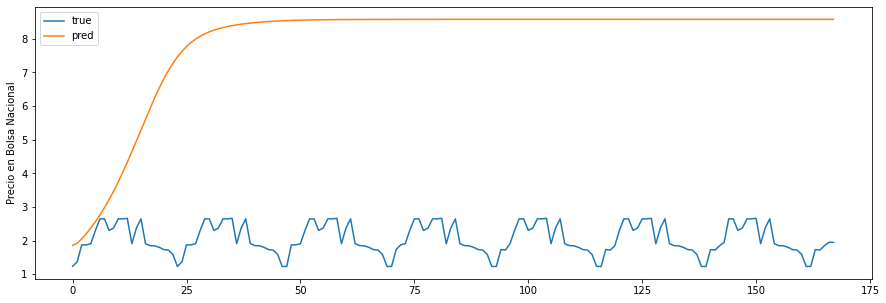

In [67]:
predictions = generate_predictions_style_3(flat_inputs,custom_gru_2)
plot_comparison(flat_inputs,predictions)

### Convolutional Neuronal Network

In [68]:
history = compile_and_fit(model=custom_cnn_2, window_train=train_generator,
                          window_val=val_generator,epochs=100,steps_per_epoch=150,
                          val_steps=150,patience=5)

Epoch 1/100
150/150 [==============================] - 4s 28ms/step - loss: 0.7284 - mean_absolute_error: 0.6252 - mean_absolute_percentage_error: 502.8954 - symmetric_mean_absolute_percentage_error: 2923.2607 - val_loss: 0.3464 - val_mean_absolute_error: 0.4825 - val_mean_absolute_percentage_error: 504.4981 - val_symmetric_mean_absolute_percentage_error: 2357.9426
Epoch 2/100
150/150 [==============================] - 2s 11ms/step - loss: 0.4556 - mean_absolute_error: 0.5147 - mean_absolute_percentage_error: 488.4904 - symmetric_mean_absolute_percentage_error: 2620.1914 - val_loss: 0.2239 - val_mean_absolute_error: 0.3844 - val_mean_absolute_percentage_error: 269.2198 - val_symmetric_mean_absolute_percentage_error: 1946.9071
Epoch 3/100
150/150 [==============================] - 2s 10ms/step - loss: 0.5665 - mean_absolute_error: 0.5266 - mean_absolute_percentage_error: 395.1584 - symmetric_mean_absolute_percentage_error: 2592.8630 - val_loss: 0.1898 - val_mean_absolute_error: 0.3364 -

In [69]:
val_performance['CNN-CustomDataset'] = custom_cnn_2.evaluate(val_generator,steps=100)
performance['CNN-CustomDataset'] = custom_cnn_2.evaluate(test_generator,steps=100, verbose=0)

100/100 [==============================] - 0s 4ms/step - loss: 0.1549 - mean_absolute_error: 0.2981 - mean_absolute_percentage_error: 295.5567 - symmetric_mean_absolute_percentage_error: 1598.7878


In [70]:
x_batch, _ = next(test_generator)

flat_inputs = tf.reshape(tf.convert_to_tensor(x_batch,dtype=np.float32), [-1,len(inputs_columns)])

**Estilo 1:** Usando todos los valores de Test.

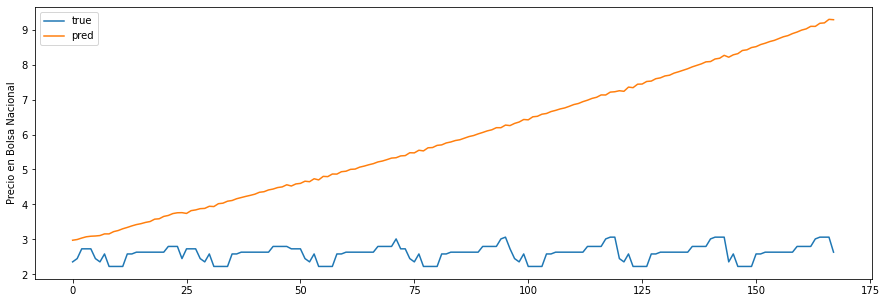

In [71]:
predictions = generate_predictions_style_1(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 2:** Usando el último valor conocido.

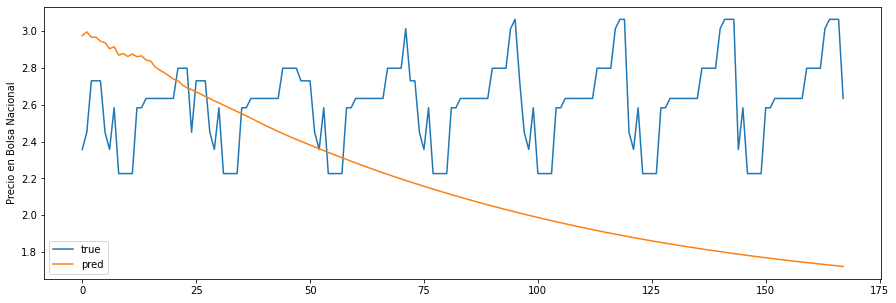

In [72]:
predictions = generate_predictions_style_2(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

**Estilo 3:** Repitiendo las 24 horas conocidas para las series que no se predicen

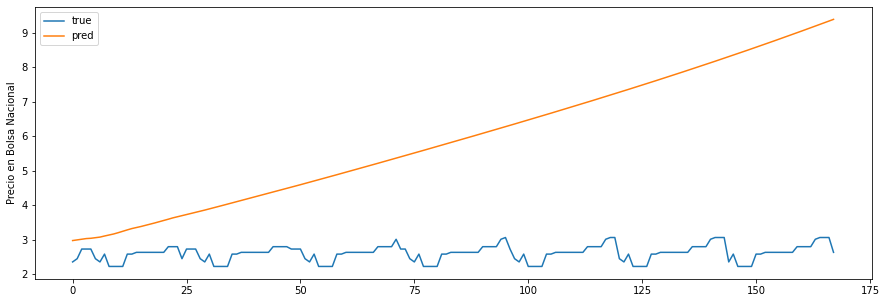

In [73]:
predictions = generate_predictions_style_3(flat_inputs,custom_cnn_2)
plot_comparison(flat_inputs,predictions)

## Metrics Summary

In [74]:
pd.DataFrame(val_performance,index=['Loss','Mean Absolute Error',
                                    'Mean Absolute Percentage Error',
                                    'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.062829,0.164816,211.194794,43.450615
LSTM,0.061678,0.167471,211.599091,44.702759
GRU,0.060610,0.156033,143.898468,41.308571
CNN,0.174074,0.316144,478.306793,68.981598
RNN-CustomDataset,0.084439,0.197129,199.539490,1194.396240
LSTM-CustomDataset,0.157271,0.305448,444.301025,1676.202393
GRU-CustomDataset,0.070041,0.157216,256.670441,988.991394
CNN-CustomDataset,0.154939,0.298109,295.556702,1598.787842


In [75]:
pd.DataFrame(performance,index=['Loss','Mean Absolute Error',
                                'Mean Absolute Percentage Error',
                                'Symetric Mean Absolute Percentage Error']).T

,Loss,Mean Absolute Error,Mean Absolute Percentage Error,Symetric Mean Absolute Percentage Error
DNN,0.067221,0.183556,17.724922,15.175248
LSTM,0.067879,0.176284,21.216074,15.013794
GRU,0.068111,0.167208,19.837584,13.839369
CNN,0.187879,0.328300,53.197319,23.715986
RNN-CustomDataset,0.082895,0.204550,23.926847,472.819031
LSTM-CustomDataset,0.178427,0.314212,35.690220,527.482971
GRU-CustomDataset,0.075637,0.176347,16.957251,301.546204
CNN-CustomDataset,0.218384,0.367593,48.353050,638.592102
